# Convulation Neural Network - Pytorch

## Possible Improvements

- higher image resolution
- larger kernel sizes
- more conovultional layers
- data augmentation

## Imports

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 
import random
import time

## Data Parameters

In [2]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 32
IMG_SIZE = (128)
VALID_PER = 0.8
SEED = 42

## Custom Dateset and Dataloader

In [3]:
import os
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        name = f"{idx}.png"
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        label_path = os.path.join(self.label_dir, os.listdir(self.label_dir)[idx])
        image = read_image(img_path)
        label = read_image(label_path)
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

In [4]:
class MyTransform:
    def __init__(self, img_size, aug_mode=True):
        self.img_size = (img_size, img_size)
        self.aug_mode = aug_mode

    def __call__(self, img, lbl):
        rotage_angle = int(random.random()*180)
        v_flip_bool = True if random.random() > 0.5 else False
        h_flip_bool = True if random.random() > 0.5 else False
        flip_bool = (v_flip_bool, h_flip_bool)
        img = self.transform(img, rotage_angle, flip_bool)
        lbl = self.transform(lbl, rotage_angle, flip_bool)
        return img, lbl

    def transform(self, x, rotage_angle, flip_bool):
        resized_img = transforms.Resize(size=self.img_size)(x)
        pil_img =transforms.ToPILImage()(resized_img)
        gray_img = transforms.functional.to_grayscale(pil_img, num_output_channels=1)
        if self.aug_mode:
            return self.augmentation(gray_img, rotage_angle, flip_bool)
        else:
            return transforms.ToTensor()(gray_img)


    def augmentation(self, img, rotage_angle, flip_bool):
        v_flip_bool, h_flip_bool = flip_bool
        aug_img = transforms.functional.rotate(img, rotage_angle)
        if v_flip_bool:
            aug_img = transforms.functional.vflip(aug_img)
        if h_flip_bool:
            aug_img = transforms.functional.vflip(aug_img)            
        return transforms.ToTensor()(aug_img)


In [5]:
def split_calculator(data, valid_per):
    number_of_file = len(os.listdir(data))
    split_length = [valid_per*number_of_file, (1-valid_per)*number_of_file]
    return [round(split_length[0]), round(split_length[1])]

In [6]:
dset = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE))

In [7]:
split_length = split_calculator(DATA_PATH_X, VALID_PER)
training_dset, validation_dset = torch.utils.data.random_split(dset, split_length, generator=torch.Generator().manual_seed(SEED))

In [8]:
training_dls = torch.utils.data.DataLoader(training_dset, batch_size=BATCH_SIZE, shuffle=True)
validation_dls = torch.utils.data.DataLoader(validation_dset, batch_size=BATCH_SIZE)

In [9]:
def status_logger(dls):
    for X, y in dls:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

In [10]:
status_logger(training_dls)
status_logger(validation_dls)

Shape of X [N, C, H, W]: torch.Size([32, 1, 128, 128])
Shape of y: torch.Size([32, 1, 128, 128]) torch.float32
Shape of X [N, C, H, W]: torch.Size([32, 1, 128, 128])
Shape of y: torch.Size([32, 1, 128, 128]) torch.float32


## Model

### Model parameters

In [11]:
epochs = 10

### Model Structure

In [12]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [13]:
model = LSNet()

In [37]:
from torch_lr_finder import LRFinder

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(training_dls, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [38]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(training_dls, val_loader=validation_dls, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
input_test = torch.rand(20, 1, IMG_SIZE, IMG_SIZE)
print(input_test.shape)
model(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 128, 128])

In [16]:
# print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

### Training and Testing functions

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    r_loss = 0
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 8 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        r_loss = loss
    return r_loss

In [18]:
def test(dataloader, model, loss_fn):
    losses = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss
    

### Training

In [34]:
def time_printer(start_time, loop_start_time, count, epochs):
        run_time = time.time() - start_time
        run_time_str = time.strftime('%H:%M:%S', time.gmtime(int(run_time)))
        loop_time = time.time() - loop_start_time
        full_time_est = (run_time / (count+1))*epochs
        full_time_str = time.strftime('%H:%M:%S', time.gmtime(int(full_time_est)))
        print("-"*30)
        print(f"Processed: {count+1} / {epochs}\nRuntime:{run_time_str}\nLooptime:{loop_time:.2f}\nEstimated runtime:{full_time_str} ")
        print("-"*30)

In [35]:
train_losses, test_losses = [], []
start_time = time.time()
for t in range(epochs):
    loop_start_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss = train(training_dls, model, loss_fn, optimizer)
    te_loss = test(validation_dls, model, loss_fn)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    time_printer(start_time, loop_start_time, t, epochs)
print("Done!")

Epoch 1
-------------------------------
loss: 0.346068  [    0/ 1200]
loss: 0.345000  [  256/ 1200]
loss: 0.353445  [  512/ 1200]
loss: 0.368140  [  768/ 1200]
loss: 0.333502  [ 1024/ 1200]
Test Error: 
 Avg loss: 0.360911 

----------
Processed: 1 / 10
Runtime:00:00:28
Looptime:28.79
Estimated runtime:00:04:47 
----------
Epoch 2
-------------------------------
loss: 0.369211  [    0/ 1200]
loss: 0.363520  [  256/ 1200]
loss: 0.368251  [  512/ 1200]


KeyboardInterrupt: 

In [20]:
n_train_losses = []
for loss in train_losses:
    n_train_losses.append(loss.item())
n_train_losses

[0.3649035692214966,
 0.3236507773399353,
 0.33582672476768494,
 0.3512742519378662,
 0.36246615648269653,
 0.3652057349681854,
 0.3456540107727051,
 0.38255101442337036,
 0.3295767605304718,
 0.40042945742607117]

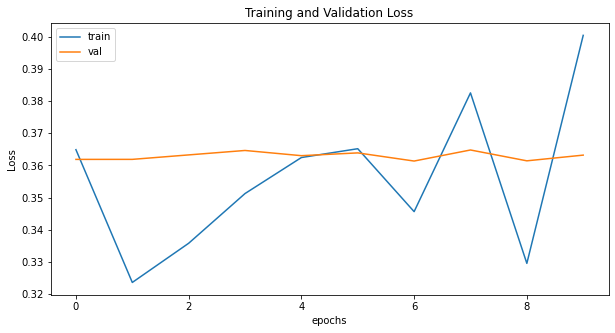

In [21]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(n_train_losses,label="train")
plt.plot(test_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Model postprocessing and evaluation

In [22]:
eval_dset  = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE, aug_mode=False))
x, y = eval_dset[20][0], eval_dset[20][1]

In [23]:
torch.save(model.state_dict(), "models/main/model_2022_08_02_14_23.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [24]:
model.eval()
print(x.shape)
print(y.shape)
with torch.no_grad():
    pred = model(x[None,:])


torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


In [25]:
new_pred = pred[0]
new_pred.shape

torch.Size([1, 128, 128])

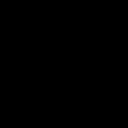

In [26]:
transforms.ToPILImage()(new_pred)

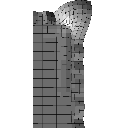

In [27]:
transforms.ToPILImage()(y)

In [28]:
eval_tfs = MyTransform((IMG_SIZE))

y_cont = []
x_cont = []
for _ in range(9):
    x_t, y_t = eval_tfs(x,y)
    y_cont.append(y_t)
    x_cont.append(x_t)

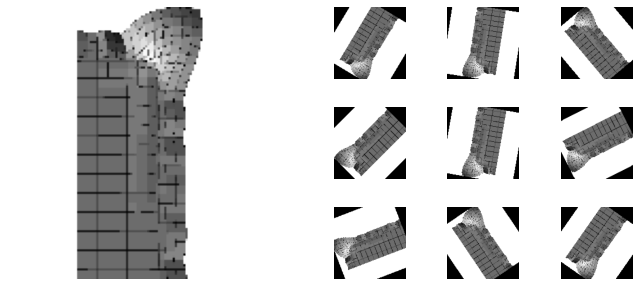

In [29]:
fig = plt.figure(figsize=(12,5))
grid = plt.GridSpec(3, 6,figure = fig, wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(grid[0:3, 0:3])
ax0.imshow(y[0], cmap='gray')
ax0.axis('off')
h = 0
for i in range(3):
    for j in range(3, 6):
        axf = fig.add_subplot(grid[i, j])
        axf.imshow(y_cont[h][0], cmap='gray')
        axf.axis('off')
        h += 1

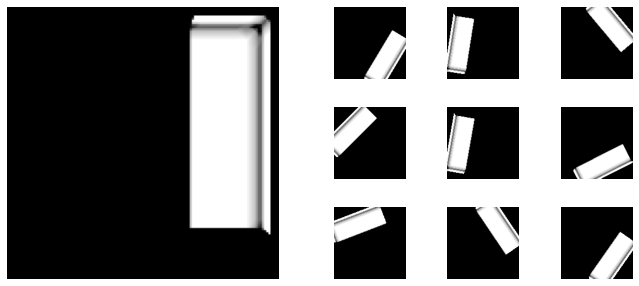

In [30]:
fig = plt.figure(figsize=(12,5))
grid = plt.GridSpec(3, 6,figure = fig, wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(grid[0:3, 0:3])
ax0.imshow(x[0], cmap='gray')
ax0.axis('off')
h = 0
for i in range(3):
    for j in range(3, 6):
        axf = fig.add_subplot(grid[i, j])
        axf.imshow(x_cont[h][0], cmap='gray')
        axf.axis('off')
        h += 1